# 0.引言

异常检测的两类常用方法：

- 基于概率分布的方法
吴恩达机器学习课程，手动code
- Isolation Forest
周志华及其学生研究提出，已经有了sklearn实现

数据集：电脑开机参数，包含两个特征 
- 等待时间
- CPU吞吐量

本示例对比两种方法的异常检测效果。由于本示例数据较为简单，因此两种方法均可以达到F1=0.875，没有显著的区分。

在实际应用中，Isolation Forest 不依赖于正态性假设和数据的连续性，可能会有更好的表现。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as scio  # 用于读取mat 数据
from scipy import stats # 用于数据的正态性检验

# 1. EDA

训练数据为**无标签**的二维数据，验证集数据有标签y。

In [2]:
data = scio.loadmat('ex8data1.mat')

In [3]:
X = data['X']                    #训练集样本特征矩阵
X_val = data['Xval']             #验证集样本特征矩阵
y_val = data['yval'].flatten()   #验证集样本标签 异常/正常 

In [4]:
print('train set shape: {}'.format(X.shape))
print('val set shape: {}'.format(X_val.shape))
print('label of val set :\n{}'.format(pd.value_counts(y_val)))

train set shape: (307, 2)
val set shape: (307, 2)
label of val set :
0    298
1      9
dtype: int64


## 1.1 正态性检验

概率分布方法分析的基础是：特征的分布服从正态分布。
检验方法：stats.shapiro

- 原假设：数据符合正态分布
- 接受假设的条件：
    - 统计量W接近1
    - 显著性水平（p-value）大于0.05
    
从训练集假设检验的结果并不完全满足正态分布。

参考：

- https://blog.csdn.net/QimaoRyan/article/details/72861387
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html

In [5]:
print('norm test of X[:,0]: ', stats.shapiro(X[:,0]))
print('norm test of X[:,1]: ', stats.shapiro(X[:,1]))

norm test of X[:,0]:  (0.818209171295166, 2.788045548629635e-18)
norm test of X[:,1]:  (0.7949155569076538, 2.2437695460625395e-19)


## 1.2 plot

可以看出

- 训练集中存在一些显著的离群异常点，没有标签，但从分布上可以清晰分辨
- 验证集的数据分布与训练集类似。

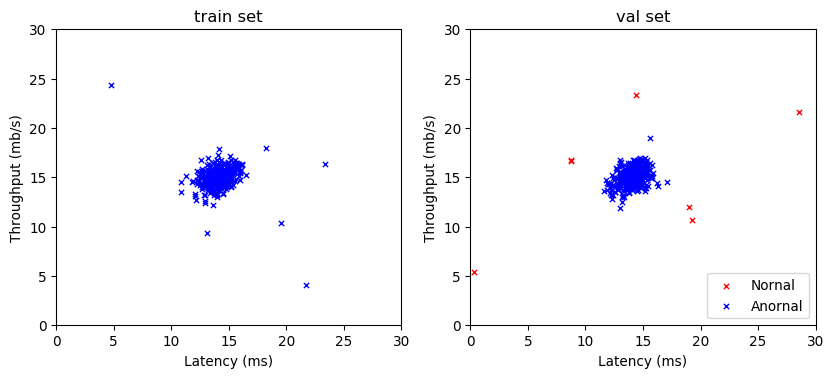

In [6]:
plt.figure(figsize=(10,4),dpi=98)
p1 = plt.subplot(121)
p2 = plt.subplot(122)

p1.scatter(X[:, 0], X[:, 1], c='b', marker='x', s=15, linewidth=1)
p1.axis([0, 30, 0, 30])
p1.set_xlabel('Latency (ms)')      #x1等待时间
p1.set_ylabel('Throughput (mb/s)') #x2吞吐量
p1.set_title('train set')


p2.scatter(X_val[y_val==1, 0], X_val[y_val==1, 1], c='r', marker='x', s=15, linewidth=1)
p2.scatter(X_val[y_val==0, 0], X_val[y_val==0, 1], c='b', marker='x', s=15, linewidth=1)
p2.axis([0, 30, 0, 30])
p2.legend(['Nornal','Anornal'], loc='lower right')
p2.set_xlabel('Latency (ms)')  #x1等待时间
p2.set_ylabel('Throughput (mb/s)') #x2吞吐量
p2.set_title('val set')

plt.show()

# 2. 概率分布异常检测方法

参考：

- https://blog.csdn.net/u013082989/article/details/53911514

## 2.1 util

In [7]:
def estimate_gaussian(X):
    #对特征矩阵的每一列求均值和方差
    mu=np.mean(X,axis=0)
    sigma2=np.var(X,axis=0)
    return mu, sigma2

In [8]:
def multivariate_gaussian(X, mu, sigma2):
    # 输入：样本，均值、方差
    # 输出：每个样本的概率值
    k = mu.size  #特征数
    # 当协方差矩阵是对角矩阵时  单元高斯分布乘积和多元高斯分布是等价的
    if sigma2.ndim == 1 or (sigma2.ndim == 2 and (sigma2.shape[1] == 1 or sigma2.shape[0] == 1)):
        sigma2 = np.diag(sigma2) # 转换成对角矩阵
    x = X - mu #对原始特征矩阵进行均值规范化
    #此时单元高斯分布乘积和多元高斯分布是等价的  所以直接用多元高斯分布公式得到训练集的概率分布
    p = (2 * np.pi) ** (-k / 2) * np.linalg.det(sigma2) ** (-0.5) * np.exp(-0.5*np.sum(np.dot(x, np.linalg.pinv(sigma2)) * x, axis=1))
    return p

In [9]:
#可视化训练集的概率分布  画出等高线图
def visualize_fit(X, mu, sigma2):
    grid = np.arange(0, 35.5, 0.5) #生成网格点
    x1, x2 = np.meshgrid(grid, grid)

    Z = multivariate_gaussian(np.c_[x1.flatten('F'), x2.flatten('F')], mu, sigma2) #得到每个网格点的概率
    Z = Z.reshape(x1.shape, order='F') 

    plt.figure() #画出训练集样本
    plt.scatter(X[:, 0], X[:, 1], marker='x', c='b', s=15, linewidth=1)

    if np.sum(np.isinf(X)) == 0:  #画出训练集概率分布的等高线图
        lvls = 10 ** np.arange(-20, 0, 3).astype(np.float)
        plt.contour(x1, x2, Z, levels=lvls, colors='r', linewidths=0.7)

In [10]:
def select_threshold(y_val, p_val):
    # 依次尝试不同的阈值，搜索使指标F1最大的阈值
    f1 = 0 #f1-score
    best_eps = 0  #最好的阈值参数
    best_f1 = 0 #最好的阈值参数对应的f1-score
    y=np.zeros(y_val.size) #存放预测值
    for epsilon in np.linspace(np.min(p_val), np.max(p_val), num=1001): #尝试不同的阈值
        #y=1 异常 ；y=0正常
        y[p_val<epsilon]=1  #预测为异常的样本
        tp=np.sum([y_val[x] for x in range(len(y)) if y[x]])  #true positive
        precision=tp/np.sum(y) #查准率
        recall=tp/np.sum(y_val)   #召回率
        
        f1=2*precision*recall/(precision+recall)  #f1-score

        if f1 > best_f1: #得到对应最高f1-score的阈值
            best_f1 = f1
            best_eps = epsilon
        y=np.zeros(y_val.size)

    return best_eps, best_f1

## 2.2 概率模型训练

概率模型实际上没有训练的过程，只需要计算出各个样本点的统计量。

注意此处计算的是各个样本的在二维数据集上的概率密度值，最大不超过0.1

In [11]:
# 参数估计 计算每个特征的均值和方差
mu, sigma2 = estimate_gaussian(X)

In [12]:
# 基于单元高斯分布得到训练集的概率分布
p = multivariate_gaussian(X, mu, sigma2)

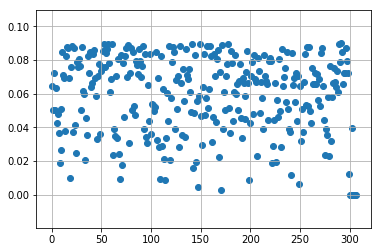

In [13]:
# 概率密度分布图
plt.scatter(x=range(len(p)), y=p)
plt.grid()
plt.show()

Text(0,0.5,'Throughput (mb/s')

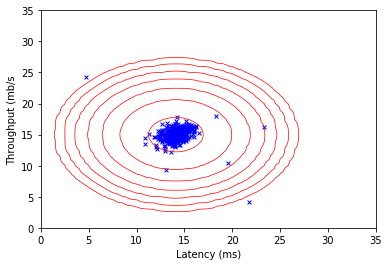

In [14]:
#可视化训练集的概率分布  画出等高线图
visualize_fit(X, mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s')

## 2.3 验证集切分阈值

概率统计方法，唯一的参数就是阈值，只需要用验证集就能切分，似乎训练集没有起到什么作用。

In [15]:
p_val = multivariate_gaussian(X_val, mu, sigma2) #根据训练集的mu sigma2 得到验证集样本的概率

In [16]:
epsilon_0, f1_0 = select_threshold(y_val, p_val)     # 搜索选择合适的概率阈值
print('Best epsilon found using cross-validation: {:0.4e}'.format(epsilon_0))
print('Best F1 on Cross Validation Set: {:0.6f}'.format(f1_0))

Best epsilon found using cross-validation: 8.9909e-05
Best F1 on Cross Validation Set: 0.875000


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


Text(0.5,1,'Probability Abnormal Detection')

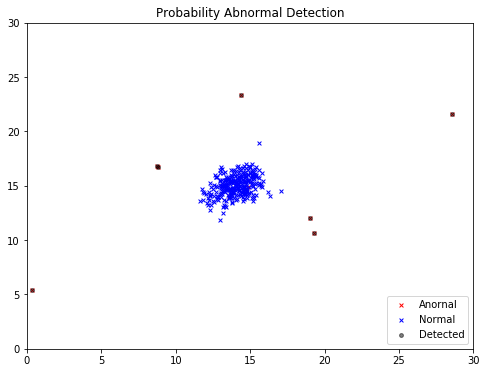

In [17]:
plt.figure(figsize=(8,6))
plt.axis([0, 30, 0, 30])
plt.scatter(X_val[y_val==1, 0], X_val[y_val==1, 1], c='r', marker='x', s=15, linewidth=1)
plt.scatter(X_val[y_val==0, 0], X_val[y_val==0, 1], c='b', marker='x', s=15, linewidth=1)
plt.scatter(X_val[p_val < epsilon_0, 0], X_val[p_val < epsilon_0, 1], c='k', marker='o', s=15, linewidth=1, alpha=0.5)
plt.legend(['Anornal','Normal','Detected'], loc='lower right')
plt.title('Probability Abnormal Detection')

In [18]:
n_anornal = sum(y_val==1)
n_detected = sum(p_val < epsilon_0)
print('y_val中的检测出数量/异常值数量：{}/{}'.format(n_detected,n_anornal))

y_val中的检测出数量/异常值数量：7/9


# 3.Isolation Forrest

参考：

- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest.decision_function
- https://www.jianshu.com/p/1b020e2605e2
- http://www.cnblogs.com/fengfenggirl/p/iForest.html


## 3.1 孤立森林建模

In [19]:
from sklearn.ensemble import IsolationForest

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [20]:
# 需要调的参数主要是 树的棵树
isf = IsolationForest(n_estimators=10,
                      n_jobs=-1,          # 使用全部cpu
                      verbose=2,
                     )

In [21]:
isf.fit(X) # 直接用无标签数据训练

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    8.1s remaining:   13.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.0s finished
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=10, n_jobs=-1, random_state=None,
        verbose=2)

## 3.2 模型评价

In [22]:
y_pred = isf.predict(X_val) # 直接评估测试集，不需要指定阈值

In [23]:
# Isolation Forrest直接给出的异常检测值，无监督，不直接用
print('Isolation Forrest prediction:')
print(pd.value_counts(y_pred))

Isolation Forrest prediction:
 1    278
-1     29
dtype: int64


In [24]:
# 通过decision_function获取异常系数值，可以理解为异常概率,选择一个最好的阈值
y_val_prob = isf.decision_function(X_val)
epsilon_1, f1_1 = select_threshold(y_val, y_val_prob)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [25]:
#验证程序正确性
print('Best epsilon found using cross-validation: {:0.4e}'.format(epsilon_1))
print('Best F1 on Cross Validation Set: {:0.6f}'.format(f1_1))

Best epsilon found using cross-validation: -6.2384e-02
Best F1 on Cross Validation Set: 0.823529


In [26]:
n_anornal = sum(y_val==1)
n_detected = sum(y_val_prob < epsilon_1)
print('y_val中的检测出数量/异常值数量：{}/{}'.format(n_detected,n_anornal))

y_val中的检测出数量/异常值数量：8/9


Text(0.5,1,'Isolation Forrest Detecton')

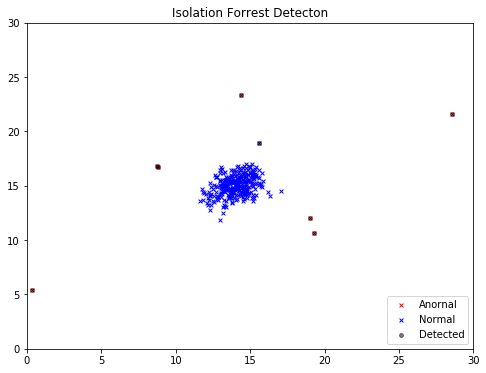

In [27]:
plt.figure(figsize=(8,6))
plt.axis([0, 30, 0, 30])
plt.scatter(X_val[y_val==1, 0], X_val[y_val==1, 1], c='r', marker='x', s=15, linewidth=1)
plt.scatter(X_val[y_val==0, 0], X_val[y_val==0, 1], c='b', marker='x', s=15, linewidth=1)
plt.scatter(X_val[y_val_prob < epsilon_1, 0], X_val[y_val_prob < epsilon_1, 1], c='k', marker='o', s=15, linewidth=1, alpha=0.5)
plt.legend(['Anornal','Normal','Detected'], loc='lower right')
plt.title('Isolation Forrest Detecton')